<a href="https://colab.research.google.com/github/indiee27/IPMI-Portfolio/blob/main/IPMI20_21_Coursework_Brain_Tumours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IPMI20-21 Coursework**
---
#**Brain Tumours Segmentation using U-Nets**

This dataset includes three types of tumour.

The analysis requires graphical processing units, **so before you start, make sure that you are connected to a GPU runtime.**

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Get brain tumour data

##Get brain tumor images
Download using the wget system command

In [ ]:
!wget -O images.py --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EYtXUEOdt7VElTHk9lW--l0BY2CqOM4QSk1h5SjrQhRHEQ?e=nmUrKZ&download=1"
!wget -O masks.py --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EcJelcxZRYBNv2FyigSizQUBS6uY3cNuXs42-DZy_0dU0g?e=h0E2gV&download=1"
!wget -O labels.py --no-check-certificate "https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EfXkm777vDVAjCbv_vTTQqYBs5eDOsmuu7Pm2ZgpsT5mPw?e=ZlcrfP&download=1"

--2021-04-13 07:27:32--  https://liveuclac-my.sharepoint.com/:u:/g/personal/ucacjhc_ucl_ac_uk/EYtXUEOdt7VElTHk9lW--l0BY2CqOM4QSk1h5SjrQhRHEQ?e=nmUrKZ&download=1
Resolving liveuclac-my.sharepoint.com (liveuclac-my.sharepoint.com)... 13.107.136.9
Connecting to liveuclac-my.sharepoint.com (liveuclac-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/ucacjhc_ucl_ac_uk/Documents/Work/Teaching/UCL/IPMI/IPMI%202019-20/brain_tumour_files/images.npy?originalPath=aHR0cHM6Ly9saXZldWNsYWMtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvdWNhY2poY191Y2xfYWNfdWsvRVl0WFVFT2R0N1ZFbFRIazlsVy0tbDBCWTJDcU9NNFFTazFoNVNqclFoUkhFUT9ydGltZT1BU19lbWszLTJFZw [following]
--2021-04-13 07:27:33--  https://liveuclac-my.sharepoint.com/personal/ucacjhc_ucl_ac_uk/Documents/Work/Teaching/UCL/IPMI/IPMI%202019-20/brain_tumour_files/images.npy?originalPath=aHR0cHM6Ly9saXZldWNsYWMtbXkuc2hhcmVwb2ludC5jb20vOnU6L2cvcGVyc29uYWwvdWNhY2poY191Y2xfYWNfdWsvRVl0WFVFT2

Check the files have loaded and are of the right size (~1.5GB, ~760MB; 25KB)

In [ ]:
!ls -lh *py

-rw-r--r-- 1 root root 1.5G Feb  7  2020 images.py
-rw-r--r-- 1 root root  25K Feb  7  2020 labels.py
-rw-r--r-- 1 root root 767M Feb  7  2020 masks.py


Load image and mask data as numpy arrays

In [ ]:
images = np.load('images.py')
masks = np.load('masks.py')
masks = masks.astype(float)
labels = np.load('labels.py')
print(images.shape)
print(images.dtype)
print(masks.shape)
print(masks.dtype)
print(labels.shape)
print(labels.dtype)

KeyboardInterrupt: ignored

Define dictionary of tumour categories

In [ ]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

Plot the number of scans per tumour type

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


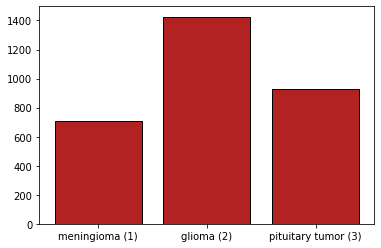

In [ ]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'],\
        color='firebrick', edgecolor='black')

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

## Plot multiple subjects

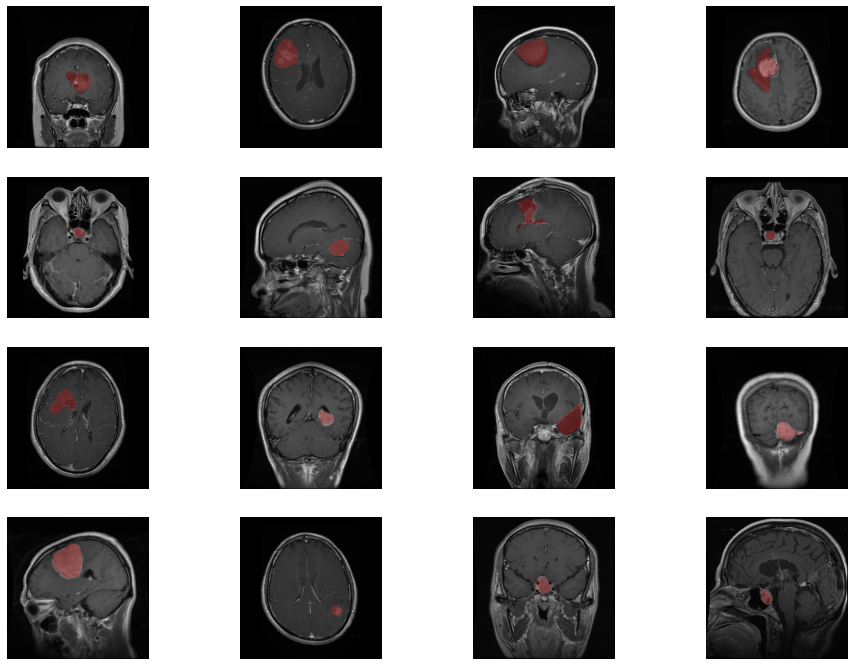

In [ ]:
plt.figure(figsize=(16, 12))
for i, idx in enumerate(np.random.randint(images.shape[0], size=16), start=1):
    plt.subplot(4, 4, i)
    plt.imshow(images[idx], cmap='gray')
    
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.3, cmap='Set1')
    plt.axis('off')

## Divide dataset by tumour class

In [ ]:
print(images.shape)

meningioma_images = images[np.where(labels == 1)]
meningioma_masks = masks[np.where(labels == 1)]
print(meningioma_images.shape)

glioma_images = images[np.where(labels == 2)]
glioma_masks = masks[np.where(labels == 2)]
print(glioma_images.shape)

pituitary_images = images[np.where(labels == 3)]
pituitary_masks = masks[np.where(labels == 3)]
print(pituitary_images.shape)

(3064, 512, 512)
(708, 512, 512)
(1426, 512, 512)
(930, 512, 512)


##Create training and test data
Need to randomly select a proportion of data for training and testing

In [ ]:
def train_test_split(image_data, mask_data, train_proportion):
    np.random.seed(38)
    train_proportion = train_proportion
    train_index = np.random.choice(image_data.shape[0], size = int(image_data.shape[0] * train_proportion), replace = False)
    print(str("Training set = ") + str("{:.0%}".format(train_proportion)) + str(", n = ") + str(len(train_index)))
    
    x_train = image_data[train_index, :, :]
    x_train = np.expand_dims(x_train, axis=3)

    y_train = mask_data[train_index, :, :]
    y_train = np.expand_dims(y_train, axis=3)

    x_test = np.delete(image_data, train_index, axis=0)
    x_test = np.expand_dims(x_test, axis=3)

    y_test = np.delete(mask_data, train_index, axis=0)
    y_test = np.expand_dims(y_test, axis=3)
    return x_train, y_train, x_test, y_test

Generate your training and test data. The inputs here are the images and corresponding mask file.<br>
You can set the proportion of data to be used for training; the remainder will be used for testing.

In [ ]:
# choose input data
input_images = glioma_images
input_masks = glioma_masks
# run train_test_split function
x_train, y_train, x_test, y_test = train_test_split(image_data = input_images, mask_data = input_masks, train_proportion = 0.8)

Training set = 80%, n = 1140


In [ ]:
print(y_train.shape)
print(x_test.shape)
print(x_test.dtype)
print(y_train.dtype)

(1140, 512, 512, 1)
(286, 512, 512, 1)
int16
float64
